## ACTD 2024 - 20

### Clases 13-14: redes neuronales para clasificación

- Redes densas
- Redes para clasificación
- Procesamiento de datos continuos y categóricos
- Funciones de activación y pérdida

Empecemos importando numpy, pandas, keras, tensorflow

In [79]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Carguemos el archivo auto-mpg.data (disponible en Bloque Neón) usando pandas. Note que debemos incluir los nombres de las columnas, además de indicar los caracteres para separación, nas y comentarios.

In [80]:
df = pd.read_csv('heart.csv')

Exploremos las primeras filas del dataframe.

In [81]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Descripción de las variables:

https://archive.ics.uci.edu/dataset/45/heart+disease


Exploremos el tamaño del df

In [82]:
df.shape

(303, 14)

Identificamos NAs en los datos

In [83]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Definimos listas para las variables categóricas enteras, categóricas string y numéricas.

In [84]:
subset_feats = ['age', 'trestbps', 'chol', 'sex', 'cp']
df = df[subset_feats+['target']]


In [85]:
df.head()

,age,trestbps,chol,sex,cp,target
0,63,145,233,1,1,0
1,67,160,286,1,4,1
2,67,120,229,1,4,0
3,37,130,250,1,3,0
4,41,130,204,0,2,0


Separamos los datos en entrenamiento, validación y prueba

In [86]:
train = df.sample(frac=0.8, random_state=100)
train.head()

,age,trestbps,chol,sex,cp,target
69,35,138,183,0,4,0
300,65,135,254,1,4,1
220,59,134,204,1,1,0
134,42,120,240,1,3,0
7,57,120,354,0,4,0


In [87]:
train.shape

(242, 6)

In [88]:
test = df.drop(train.index)
test.head()

,age,trestbps,chol,sex,cp,target
0,63,145,233,1,1,0
2,67,120,229,1,4,0
4,41,130,204,0,2,0
8,63,130,254,1,4,1
13,44,120,263,1,2,0


In [89]:
val = train.sample(frac=0.2, random_state=100)

In [90]:
val.shape

(48, 6)

In [91]:
train = train.drop(val.index)

In [92]:
print(train.shape)
print(val.shape)
print(test.shape)

(194, 6)
(48, 6)
(61, 6)


Calculamos estadísticas de cada variable numérica

In [93]:
train.describe()

,age,trestbps,chol,sex,cp,target
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,54.953608,132.876289,249.974227,0.664948,3.097938,0.257732
std,8.754150,17.952879,52.803226,0.473230,1.030969,0.438517
min,34.000000,94.000000,126.000000,0.000000,0.000000,0.000000
25%,49.000000,120.000000,215.750000,0.000000,2.000000,0.000000
50%,56.000000,130.000000,243.000000,1.000000,3.000000,0.000000
75%,61.000000,143.500000,281.000000,1.000000,4.000000,1.000000
max,77.000000,192.000000,564.000000,1.000000,4.000000,1.000000


Función para convertir de dataframe (pandas) a dataset (tensorflow), separando características y etiquetas

In [94]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [95]:
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

In [96]:
type(train_ds)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

Ejemplo de cómo queda el tf.dataset

In [97]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=62>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=244>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Separamos los datos de entrenamiento, validación y prueba en lotes

In [98]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Función para codificar variables numéricas (Keras docs)

In [99]:
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

Función para codificar variables categóricas (Keras docs)

In [100]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para retornas variables 0/1 (dummies)
    # lookup: busca el valor correspondiente de la variable categórica
    lookup = lookup_class(output_mode="binary")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

Creamos una lista de inputs para el modelo, de acuerdo con cada tipo de variable

In [101]:
inputs = {
    'age': keras.Input(shape=(1,), name='age'),
    'trestbps': keras.Input(shape=(1,), name='trestbps'),
    'chol': keras.Input(shape=(1,), name='chol'),
    'sex': keras.Input(shape=(1,), name='sex', dtype='int64'),
    'cp': keras.Input(shape=(1,), name='cp', dtype='int64')
}

In [102]:
for i in inputs:
   print(i)

age
trestbps
chol
sex
cp


Creamos una lista de variables codificadas/normalizadas de acuerdo con su tipo, empleando las funciones de codificación/normalización

In [103]:
feats_encoded = [
    encode_numerical_feature(inputs['age'], 'age', train_ds),
    encode_numerical_feature(inputs['trestbps'], 'trestbps', train_ds),
    encode_numerical_feature(inputs['chol'], 'chol', train_ds),
    encode_categorical_feature(inputs['sex'], 'sex', train_ds, False),  # 'sex' es categórica (entero)
    encode_categorical_feature(inputs['cp'], 'cp', train_ds, False)  # 'cp' es categórica (entero)
]

In [104]:
len_feats = len(feats_encoded)
len_feats

5

In [105]:
for i in feats_encoded:
  print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_6/truediv:0', description="created by layer 'normalization_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_7/truediv:0', description="created by layer 'normalization_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_8/truediv:0', description="created by layer 'normalization_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_4/bincount/DenseBincount:0', description="created by layer 'integer_lookup_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='integer_lookup_5/bincount/DenseBincount:0', description="created by layer 'integer_lookup_5'")


Creamos una capa concatenando todas las variables codificadas

In [106]:
all_feats = keras.layers.concatenate(feats_encoded)

In [107]:
type(all_feats)

keras.src.engine.keras_tensor.KerasTensor

Agregamos una capa densa con 32 neuronas y función de activación relu

In [108]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)

Agregamos la capa de salida con 1 neurona (probabilidad de sufrir la enfermedad cardiada) y función de activación sigmoide

In [109]:
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

Creamos el modelo con las capas ya creadas y las variables de entrada

In [110]:
model = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [111]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [112]:
#keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Aseguramos que Keras use TensorFlow como backend, para asegurar que el modelo pueda usar strings como entradas

In [113]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

Entrenamos el modelo con los datos en el formato tf.Dataset

In [114]:
history=model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 1s 24ms/step - loss: 0.6865 - accuracy: 0.5464 - val_loss: 0.6614 - val_accuracy: 0.6458
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.5979 - val_loss: 0.6403 - val_accuracy: 0.7083
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6186 - val_loss: 0.6217 - val_accuracy: 0.7500
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6959 - val_loss: 0.6051 - val_accuracy: 0.7500
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.7268 - val_loss: 0.5921 - val_accuracy: 0.7500
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 0.5953 - accuracy: 0.7423 - val_loss: 0.5821 - val_accuracy: 0.7500
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 0.5843 - accuracy: 0.7423 - val_loss: 0.5732 - val_accuracy: 0.7500
Epoch 8/50
7/7 [=================

Graficar la pérdida de entrenamiento y validación

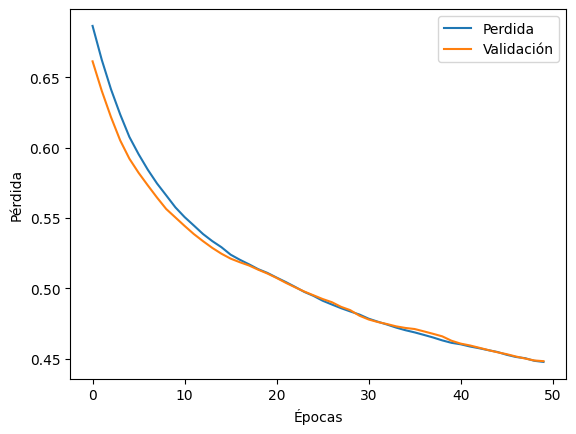

In [115]:
plt.plot(history.history['loss'], label='Perdida')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Hacer predicciones en el set de prueba

In [116]:

y_true = []
y_pred = []
for x, y in test_ds:
    y_true.extend(list(y.numpy()))
    y_pred.extend(list(model.predict(x).flatten()))

# Convertir las predicciones a binario (0 o 1)
y_pred_bin = [1 if pred >= 0.5 else 0 for pred in y_pred]


1/1 [==============================] - 0s 87ms/step


Calcular las métricas

In [118]:
from sklearn.metrics import classification_report, confusion_matrix


# Calcular métricas
print(classification_report(y_true, y_pred_bin, target_names=['No enfermedad', 'Enfermedad']))
print("Matriz de confusión:\n", confusion_matrix(y_true,y_pred_bin))

               precision    recall  f1-score   support

No enfermedad       0.73      0.93      0.81        40
   Enfermedad       0.70      0.33      0.45        21

     accuracy                           0.72        61
    macro avg       0.71      0.63      0.63        61
 weighted avg       0.72      0.72      0.69        61

Matriz de confusión:
 [[37  3]
 [14  7]]
